In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, itertools 

from statsmodels.tsa.arima_model import ARIMA 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore") 

## Store Total Data 

For this notebook, I simplify the analysis and aggregate all departments together to produce sales by store. I furthermore only model one store and perform extensive visualization and diagnostics as I proceed. I will next generalize to more stores.

In [3]:
train = pd.read_csv('../data/train.csv')
train.columns = train.columns.str.lower()
train.set_index('date', inplace=True)

weekly_sales = train.groupby([train.index, 'store']).sum()[['weekly_sales']]
weekly_sales = weekly_sales.reset_index(level=1)

train, test = train_test_split(weekly_sales, test_size = 0.2, shuffle = False)

## Baseline Model

Our simple baseline model will be predicting a store's sales for the following week will equal the previous week. Given the statinary of weekly sales for most stores, this shouldn't be a terrible prediction for most stores. This will not account for any trends in sales or seasonality effects.

In [4]:
base_RMSE = np.empty(45)
base_pct = np.empty(45)
for sid in range(1,46):
    store_sales = test.loc[test['store']==(sid), ['weekly_sales']]
    base_RMSE[sid-1] = (np.sqrt((test['weekly_sales'].diff().dropna()**2).mean()))
    base_pct[sid-1] = (abs(test['weekly_sales'].diff())/(test['weekly_sales'])).dropna().mean()*100

print('Average Store Level RMSE: {:.0f}'.format(base_RMSE.mean()))
print('Average Store Level Percent Error: {:.2f}'.format(base_pct.mean()))

Average Store Level RMSE: 765620
Average Store Level Percent Error: 83.73


## ARMA Model

We choose a few stores to model alone to explore time-lags, differences, and moving-average components of our time series model before moving to the vector version which we will use across all stores.

In [5]:
store_1 = weekly_sales.loc[weekly_sales['store']==1,:].drop(columns='store')
store_2 = weekly_sales.loc[weekly_sales['store']==2,:].drop(columns='store')
store_3 = weekly_sales.loc[weekly_sales['store']==3,:].drop(columns='store')

store_1_train, store_1_test = train_test_split(store_1, test_size = 0.2, shuffle = False)
store_2_train, store_2_test = train_test_split(store_2, test_size = 0.2, shuffle = False)
store_3_train, store_3_test = train_test_split(store_3, test_size = 0.2, shuffle = False)

In [6]:
store_1 = weekly_sales.loc[weekly_sales['store']==1,'weekly_sales']
store_2 = weekly_sales.loc[weekly_sales['store']==2,'weekly_sales']
store_3 = weekly_sales.loc[weekly_sales['store']==3,'weekly_sales']

store_1_train, store_1_test = train_test_split(store_1, test_size = 0.2, shuffle = False)
store_2_train, store_2_test = train_test_split(store_2, test_size = 0.2, shuffle = False)
store_3_train, store_3_test = train_test_split(store_3, test_size = 0.2, shuffle = False)

#### (1,0,0)

Store 1 - Min: 1437059, Max: 1769854, Mean: 1571676
Store 1 - Train RMSE: 160477, Test RMSE: 82505
 
Store 1 - Min: 1746471, Max: 2041507, Mean: 1891015
Store 2 - Train RMSE: 241427, Test RMSE: 88955
 
Store 3 - Min: 389428, Max: 446337, Mean: 417221
Store 3 - Train RMSE: 42748, Test RMSE: 23310


''

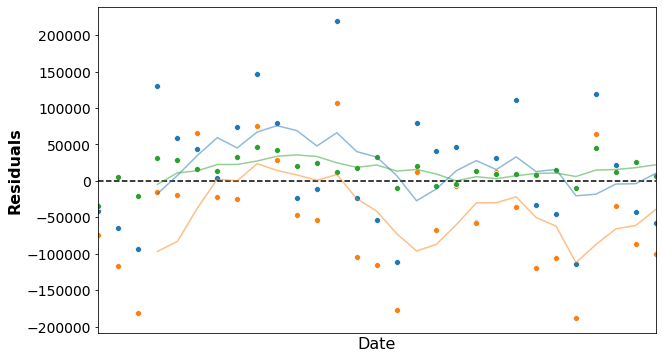

In [7]:
arima1 = ARIMA(endog = store_1_train,order = (1, 0, 0))
ar1 = arima1.fit()
pred1_train = arima1.predict(params = ar1.params, start = store_1_train.index[0], end = store_1_train.index[-1])
pred1_test = arima1.predict(params = ar1.params, start = store_1_test.index[0], end = store_1_test.index[-1])

arima2 = ARIMA(endog = store_2_train,order = (1, 0, 0))
ar2 = arima2.fit()
pred2_train = arima2.predict(params = ar2.params, start = store_2_train.index[0], end = store_2_train.index[-1])
pred2_test = arima2.predict(params = ar2.params, start = store_2_test.index[0], end = store_2_test.index[-1])

arima3 = ARIMA(endog = store_3_train,order = (1, 0, 0))
ar3 = arima3.fit()
pred3_train = arima3.predict(params = ar3.params, start = store_3_train.index[0], end = store_3_train.index[-1])
pred3_test = arima3.predict(params = ar3.params, start = store_3_test.index[0], end = store_3_test.index[-1])



rmse_train_100 = [np.sqrt(mean_squared_error(store_1_train, pred1_train)),
                 np.sqrt(mean_squared_error(store_2_train, pred2_train)),
                 np.sqrt(mean_squared_error(store_3_train, pred3_train))]
rmse_test_100 = [np.sqrt(mean_squared_error(store_1_test, pred1_test)),
                 np.sqrt(mean_squared_error(store_2_test, pred2_test)),
                 np.sqrt(mean_squared_error(store_3_test, pred3_test))]

print('Store 1 - Min: {:.0f}, Max: {:.0f}, Mean: {:.0f}'.format( \
        store_1_test.min(), store_1_test.max(), store_1_test.mean()))
print('Store 1 - Train RMSE: {:.0f}, Test RMSE: {:.0f}'.format( \
        rmse_train_100[0], rmse_test_100[0]))
print(' ')
print('Store 1 - Min: {:.0f}, Max: {:.0f}, Mean: {:.0f}'.format( \
        store_2_test.min(), store_2_test.max(), store_2_test.mean()))
print('Store 2 - Train RMSE: {:.0f}, Test RMSE: {:.0f}'.format( \
        rmse_train_100[1], rmse_test_100[1]))
print(' ')
print('Store 3 - Min: {:.0f}, Max: {:.0f}, Mean: {:.0f}'.format( \
        store_3_test.min(), store_3_test.max(), store_3_test.mean()))
print('Store 3 - Train RMSE: {:.0f}, Test RMSE: {:.0f}'.format( \
        rmse_train_100[2], rmse_test_100[2]))

plt.figure(figsize=(10,6))

res1 = store_1_test - pred1_test
res2 = store_2_test - pred2_test
res3 = store_3_test - pred3_test

sns.scatterplot(x = res1.index, y=res1)
sns.scatterplot(x = res2.index, y=res2)
sns.scatterplot(x = res3.index, y=res3)
sns.lineplot(x = res1.index[3:], y = res1.rolling(4).mean()[3:], alpha = 0.5)
sns.lineplot(x = res2.index[3:], y = res2.rolling(4).mean()[3:], alpha = 0.5)
sns.lineplot(x = res3.index[3:], y = res3.rolling(4).mean()[3:], alpha = 0.5)


plt.hlines(y = 0,
           xmin = store_1_test.index.min(),
           xmax = store_1_test.index.max(),
           linestyles = '--')

plt.xlabel('Date', fontsize=16)
plt.xticks([])
plt.xlim(store_1_test.index.min(), store_1_test.index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 16, fontweight='bold')
;

#### (2,0,0)

Store 1 - Min: 1437059, Max: 1769854, Mean: 1571676
Store 1 - Train RMSE: 160173, Test RMSE: 83097
 
Store 1 - Min: 1746471, Max: 2041507, Mean: 1891015
Store 2 - Train RMSE: 239967, Test RMSE: 89816
 
Store 3 - Min: 389428, Max: 446337, Mean: 417221
Store 3 - Train RMSE: 42389, Test RMSE: 22182


''

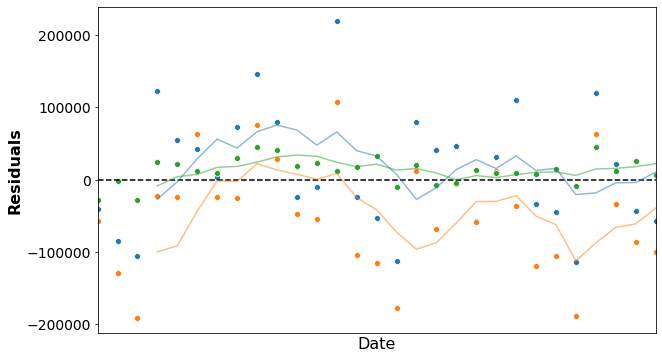

In [8]:
arima1 = ARIMA(endog = store_1_train,order = (2, 0, 0))
ar1 = arima1.fit()
pred1_train = arima1.predict(params = ar1.params, start = store_1_train.index[0], end = store_1_train.index[-1])
pred1_test = arima1.predict(params = ar1.params, start = store_1_test.index[0], end = store_1_test.index[-1])

arima2 = ARIMA(endog = store_2_train,order = (2, 0, 0))
ar2 = arima2.fit()
pred2_train = arima2.predict(params = ar2.params, start = store_2_train.index[0], end = store_2_train.index[-1])
pred2_test = arima2.predict(params = ar2.params, start = store_2_test.index[0], end = store_2_test.index[-1])

arima3 = ARIMA(endog = store_3_train,order = (2, 0, 0))
ar3 = arima3.fit()
pred3_train = arima3.predict(params = ar3.params, start = store_3_train.index[0], end = store_3_train.index[-1])
pred3_test = arima3.predict(params = ar3.params, start = store_3_test.index[0], end = store_3_test.index[-1])



rmse_train_200 = [np.sqrt(mean_squared_error(store_1_train, pred1_train)),
                 np.sqrt(mean_squared_error(store_2_train, pred2_train)),
                 np.sqrt(mean_squared_error(store_3_train, pred3_train))]
rmse_test_200 = [np.sqrt(mean_squared_error(store_1_test, pred1_test)),
                 np.sqrt(mean_squared_error(store_2_test, pred2_test)),
                 np.sqrt(mean_squared_error(store_3_test, pred3_test))]

print('Store 1 - Min: {:.0f}, Max: {:.0f}, Mean: {:.0f}'.format( \
        store_1_test.min(), store_1_test.max(), store_1_test.mean()))
print('Store 1 - Train RMSE: {:.0f}, Test RMSE: {:.0f}'.format( \
        rmse_train_200[0], rmse_test_200[0]))
print(' ')
print('Store 1 - Min: {:.0f}, Max: {:.0f}, Mean: {:.0f}'.format( \
        store_2_test.min(), store_2_test.max(), store_2_test.mean()))
print('Store 2 - Train RMSE: {:.0f}, Test RMSE: {:.0f}'.format( \
        rmse_train_200[1], rmse_test_200[1]))
print(' ')
print('Store 3 - Min: {:.0f}, Max: {:.0f}, Mean: {:.0f}'.format( \
        store_3_test.min(), store_3_test.max(), store_3_test.mean()))
print('Store 3 - Train RMSE: {:.0f}, Test RMSE: {:.0f}'.format( \
        rmse_train_200[2], rmse_test_200[2]))



plt.figure(figsize=(10,6))

res1 = store_1_test - pred1_test
res2 = store_2_test - pred2_test
res3 = store_3_test - pred3_test

sns.scatterplot(x = res1.index, y=res1)
sns.scatterplot(x = res2.index, y=res2)
sns.scatterplot(x = res3.index, y=res3)
sns.lineplot(x = res1.index[3:], y = res1.rolling(4).mean()[3:], alpha = 0.5)
sns.lineplot(x = res2.index[3:], y = res2.rolling(4).mean()[3:], alpha = 0.5)
sns.lineplot(x = res3.index[3:], y = res3.rolling(4).mean()[3:], alpha = 0.5)

plt.hlines(y = 0,
           xmin = store_1_test.index.min(),
           xmax = store_1_test.index.max(),
           linestyles = '--')

plt.xlabel('Date', fontsize=16)
plt.xticks([])
plt.xlim(store_1_test.index.min(), store_1_test.index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 16, fontweight='bold')
;

#### (1,0,1)

Store 1 - Min: 1437059, Max: 1769854, Mean: 1571676
Store 1 - Train RMSE: 160081, Test RMSE: 83011
 
Store 1 - Min: 1746471, Max: 2041507, Mean: 1891015
Store 2 - Train RMSE: 240186, Test RMSE: 89491
 
Store 3 - Min: 389428, Max: 446337, Mean: 417221
Store 3 - Train RMSE: 42115, Test RMSE: 20770


''

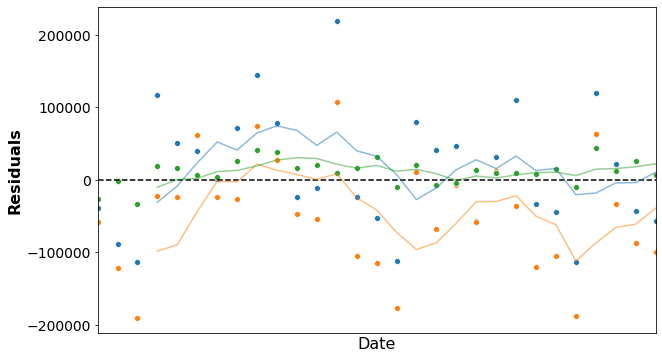

In [9]:
arima1 = ARIMA(endog = store_1_train,order = (1, 0, 1))
ar1 = arima1.fit()
pred1_train = arima1.predict(params = ar1.params, start = store_1_train.index[0], end = store_1_train.index[-1])
pred1_test = arima1.predict(params = ar1.params, start = store_1_test.index[0], end = store_1_test.index[-1])

arima2 = ARIMA(endog = store_2_train,order = (1, 0, 1))
ar2 = arima2.fit()
pred2_train = arima2.predict(params = ar2.params, start = store_2_train.index[0], end = store_2_train.index[-1])
pred2_test = arima2.predict(params = ar2.params, start = store_2_test.index[0], end = store_2_test.index[-1])

arima3 = ARIMA(endog = store_3_train,order = (1, 0, 1))
ar3 = arima3.fit()
pred3_train = arima3.predict(params = ar3.params, start = store_3_train.index[0], end = store_3_train.index[-1])
pred3_test = arima3.predict(params = ar3.params, start = store_3_test.index[0], end = store_3_test.index[-1])



rmse_train_101 = [np.sqrt(mean_squared_error(store_1_train, pred1_train)),
                 np.sqrt(mean_squared_error(store_2_train, pred2_train)),
                 np.sqrt(mean_squared_error(store_3_train, pred3_train))]
rmse_test_101 = [np.sqrt(mean_squared_error(store_1_test, pred1_test)),
                 np.sqrt(mean_squared_error(store_2_test, pred2_test)),
                 np.sqrt(mean_squared_error(store_3_test, pred3_test))]

print('Store 1 - Min: {:.0f}, Max: {:.0f}, Mean: {:.0f}'.format( \
        store_1_test.min(), store_1_test.max(), store_1_test.mean()))
print('Store 1 - Train RMSE: {:.0f}, Test RMSE: {:.0f}'.format( \
        rmse_train_101[0], rmse_test_101[0]))
print(' ')
print('Store 1 - Min: {:.0f}, Max: {:.0f}, Mean: {:.0f}'.format( \
        store_2_test.min(), store_2_test.max(), store_2_test.mean()))
print('Store 2 - Train RMSE: {:.0f}, Test RMSE: {:.0f}'.format( \
        rmse_train_101[1], rmse_test_101[1]))
print(' ')
print('Store 3 - Min: {:.0f}, Max: {:.0f}, Mean: {:.0f}'.format( \
        store_3_test.min(), store_3_test.max(), store_3_test.mean()))
print('Store 3 - Train RMSE: {:.0f}, Test RMSE: {:.0f}'.format( \
        rmse_train_101[2], rmse_test_101[2]))



plt.figure(figsize=(10,6))

res1 = store_1_test - pred1_test
res2 = store_2_test - pred2_test
res3 = store_3_test - pred3_test

sns.scatterplot(x = res1.index, y=res1)
sns.scatterplot(x = res2.index, y=res2)
sns.scatterplot(x = res3.index, y=res3)
sns.lineplot(x = res1.index[3:], y = res1.rolling(4).mean()[3:], alpha = 0.5)
sns.lineplot(x = res2.index[3:], y = res2.rolling(4).mean()[3:], alpha = 0.5)
sns.lineplot(x = res3.index[3:], y = res3.rolling(4).mean()[3:], alpha = 0.5)

plt.hlines(y = 0,
           xmin = store_1_test.index.min(),
           xmax = store_1_test.index.max(),
           linestyles = '--')

plt.xlabel('Date', fontsize=16)
plt.xticks([])
plt.xlim(store_1_test.index.min(), store_1_test.index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 16, fontweight='bold')
;

#### (2,0,2)

Store 1 - Min: 1437059, Max: 1769854, Mean: 1571676
Store 1 - Train RMSE: 158111, Test RMSE: 83922
 
Store 1 - Min: 1746471, Max: 2041507, Mean: 1891015
Store 2 - Train RMSE: 236134, Test RMSE: 90940
 
Store 3 - Min: 389428, Max: 446337, Mean: 417221
Store 3 - Train RMSE: 42101, Test RMSE: 20658


''

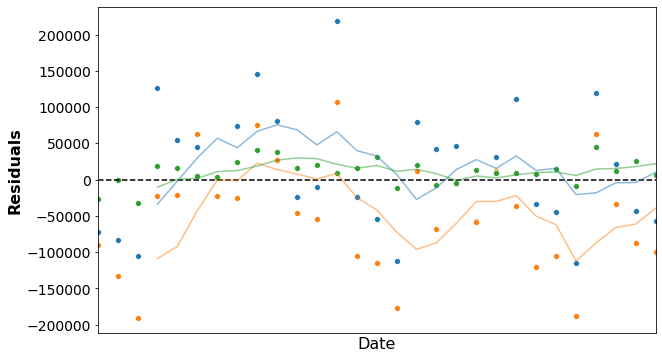

In [10]:
arima1 = ARIMA(endog = store_1_train,order = (2, 0, 1))
ar1 = arima1.fit()
pred1_train = arima1.predict(params = ar1.params, start = store_1_train.index[0], end = store_1_train.index[-1])
pred1_test = arima1.predict(params = ar1.params, start = store_1_test.index[0], end = store_1_test.index[-1])

arima2 = ARIMA(endog = store_2_train,order = (2, 0, 1))
ar2 = arima2.fit()
pred2_train = arima2.predict(params = ar2.params, start = store_2_train.index[0], end = store_2_train.index[-1])
pred2_test = arima2.predict(params = ar2.params, start = store_2_test.index[0], end = store_2_test.index[-1])

arima3 = ARIMA(endog = store_3_train,order = (2, 0, 1))
ar3 = arima3.fit()
pred3_train = arima3.predict(params = ar3.params, start = store_3_train.index[0], end = store_3_train.index[-1])
pred3_test = arima3.predict(params = ar3.params, start = store_3_test.index[0], end = store_3_test.index[-1])



rmse_train_201 = [np.sqrt(mean_squared_error(store_1_train, pred1_train)),
                 np.sqrt(mean_squared_error(store_2_train, pred2_train)),
                 np.sqrt(mean_squared_error(store_3_train, pred3_train))]
rmse_test_201 = [np.sqrt(mean_squared_error(store_1_test, pred1_test)),
                 np.sqrt(mean_squared_error(store_2_test, pred2_test)),
                 np.sqrt(mean_squared_error(store_3_test, pred3_test))]

print('Store 1 - Min: {:.0f}, Max: {:.0f}, Mean: {:.0f}'.format( \
        store_1_test.min(), store_1_test.max(), store_1_test.mean()))
print('Store 1 - Train RMSE: {:.0f}, Test RMSE: {:.0f}'.format( \
        rmse_train_201[0], rmse_test_201[0]))
print(' ')
print('Store 1 - Min: {:.0f}, Max: {:.0f}, Mean: {:.0f}'.format( \
        store_2_test.min(), store_2_test.max(), store_2_test.mean()))
print('Store 2 - Train RMSE: {:.0f}, Test RMSE: {:.0f}'.format( \
        rmse_train_201[1], rmse_test_201[1]))
print(' ')
print('Store 3 - Min: {:.0f}, Max: {:.0f}, Mean: {:.0f}'.format( \
        store_3_test.min(), store_3_test.max(), store_3_test.mean()))
print('Store 3 - Train RMSE: {:.0f}, Test RMSE: {:.0f}'.format( \
        rmse_train_201[2], rmse_test_201[2]))



plt.figure(figsize=(10,6))

res1 = store_1_test - pred1_test
res2 = store_2_test - pred2_test
res3 = store_3_test - pred3_test

sns.scatterplot(x = res1.index, y=res1)
sns.scatterplot(x = res2.index, y=res2)
sns.scatterplot(x = res3.index, y=res3)
sns.lineplot(x = res1.index[3:], y = res1.rolling(4).mean()[3:], alpha = 0.5)
sns.lineplot(x = res2.index[3:], y = res2.rolling(4).mean()[3:], alpha = 0.5)
sns.lineplot(x = res3.index[3:], y = res3.rolling(4).mean()[3:], alpha = 0.5)

plt.hlines(y = 0,
           xmin = store_1_test.index.min(),
           xmax = store_1_test.index.max(),
           linestyles = '--')

plt.xlabel('Date', fontsize=16)
plt.xticks([])
plt.xlim(store_1_test.index.min(), store_1_test.index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 16, fontweight='bold')
;

### Summary

In [11]:
rmse_test_df = pd.DataFrame(list(zip(rmse_test_100,rmse_test_200,rmse_test_101,rmse_test_201)), 
            index = range(1,4), columns = ['AR(1)', 'AR(2)', 'ARMA(1,1)', 'ARMA(2,1)'])
rmse_test_df = round(rmse_test_df,0)
rmse_test_df


,AR(1),AR(2),"ARMA(1,1)","ARMA(2,1)"
1,82505.0,83097.0,83011.0,83922.0
2,88955.0,89816.0,89491.0,90940.0
3,23310.0,22182.0,20770.0,20658.0


Our 3 cases suggest that either AR(1) or ARMA(1,1) performs best compared to the 2 other alternatives. However, our residuals clearly display a cyclical pattern. We need to control for seasonality.

## SARIMA Model

In [16]:
p,d,q = range(1, 3), range(2), range(0,3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(range(2), range(2), range(2), range(50,53)))]


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(store_1_train.astype(float).dropna(),
                          order=param,
                          seasonal_order=param_seasonal)
            mod.fit()
            pred = mod.predict(start=store_1_test.index[0], end = store_1_test.index[-1])

            if mean_squared_error(store_1_test, pred) < final_mse:
                final_mse = mean_squared_error(store_1_test, pred)
                final_param.append([param, param_seasonal])
                
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue